# Single Cell Analysis and Data processing for QuPath segmentation

# Prerequisites

In [4]:
library(imcRtools)
library(dittoSeq)
library(tidyverse)
library(ggplot2)

Loading required package: SpatialExperiment

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, 

In [5]:
set_base_dir_method <- "Relative"

In [6]:
if (set_base_dir_method == "Relative") {
    notebook_dir <- getwd()
    data_dir <- fs::path_dir(notebook_dir)
} else if (set_base_dir_method == "Manual") {
    data_dir = "/path/to/data/directory"
}

In [7]:
# set the base directory
base_dir = data_dir

In [8]:
results_dir = fs::path_join(c(base_dir, "analysis"))
results_graphs_dir = fs::path_join(c(base_dir, "analysis", "graphs"))
results_objects_dir = fs::path_join(c(base_dir, "analysis", "objects"))
cell_table_dir_qupath = fs::path_join(c(base_dir, "segmentation","cell_table_qupath"))
cell_table_dir_qc = fs::path_join(c(base_dir, "segmentation", "cell_table"))

In [9]:
for (directory in c(results_dir, results_graphs_dir, results_objects_dir)) {
    dir.create(directory,showWarnings = FALSE)
}

# Reading in Data from custom files


In [10]:

# Only using the normalized counts here
cur_features <- read_csv(fs::path_join(c(cell_table_dir_qupath, "measurements.csv")))

dim(cur_features)
colnames(cur_features)

markers_list_QuPath <- colnames(cur_features)[12:34]
length(markers_list_QuPath)

counts <- cur_features[,markers_list_QuPath]
colnames(counts) <- str_extract(colnames(counts), "(?<=Cell: )[A-Z0-9_]+(?= mean)")

cur_features$Image <- gsub("\\.ome\\.tiff.*", "", cur_features$Image)

meta <- cur_features[,c("Image", "Object ID", "Cell: Area", "Parent")]

colnames(meta) <- c("fov", "ObjectNumber", "area", "patient_id")


coords <- cur_features[,c("Centroid X µm", "Centroid Y µm")]
colnames(coords) <- c("adj_x", "adj_y")


Rows: 58226 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Image, Object ID, Object type, Parent, ROI
dbl (28): Centroid X µm, Centroid Y µm, Cell: Area, Cell: Circularity, Cell:...
lgl  (1): Name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 58226    34

[1] "Image"                  "Object ID"              "Object type"           
 [4] "Name"                   "Parent"                 "ROI"                   
 [7] "Centroid X µm"          "Centroid Y µm"          "Cell: Area"            
[10] "Cell: Circularity"      "Cell: Eccentricity"     "Cell: DAPI_INIT mean"  
[13] "Cell: DAPI_FINAL mean"  "Cell: ASMA mean"        "Cell: CCL19 mean"      
[16] "Cell: CD11C mean"       "Cell: CD146 mean"       "Cell: CD3 mean"        
[19] "Cell: CD31 mean"        "Cell: CD4 mean"         "Cell: CD45 mean"       
[22] "Cell: CD68 mean"        "Cell: CD8 mean"         "Cell: CD90 mean"       
[25] "Cell: CDH11 mean"       "Cell: CK8 mean"         "Cell: HLADR mean"      
[28] "Cell: MERTK mean"       "Cell: PANCADHERIN mean" "Cell: PDGFRA mean"     
[31] "Cell: PDPN mean"        "Cell: PSTAT1 mean"      "Cell: SPARC mean"      
[34] "Cell: VIM mean"

[1] 23

In [11]:
meta$patient_id <- meta$fov
head(meta)

fov,ObjectNumber,area,patient_id
<chr>,<chr>,<dbl>,<chr>
GI_6717_3_region_001,603d575f-eb89-425f-9609-826f28da9898,160,GI_6717_3_region_001
GI_6717_3_region_001,70dd8902-16ed-442d-858b-4d1d2aad2220,1058,GI_6717_3_region_001
GI_6717_3_region_001,4bd13a50-fb05-4137-9364-f31ce0fe261d,137,GI_6717_3_region_001
GI_6717_3_region_001,a93e4416-bde4-42ff-8387-30f3fb5f244c,412,GI_6717_3_region_001
GI_6717_3_region_001,778ad0f7-1bc0-40ed-86fb-58c481b93a14,102,GI_6717_3_region_001
GI_6717_3_region_001,40ea1b6a-cbaf-4344-8222-d16323d267b8,189,GI_6717_3_region_001


In [12]:

spe_QuPath_ananya <- SpatialExperiment(assays = list(counts = t(counts)),
                          colData = meta, 
                          sample_id = meta$fov,
                          spatialCoords = as.matrix(coords))



In [13]:
colnames(spe_QuPath_ananya) <- paste0(spe_QuPath_ananya$sample_id, "_", spe_QuPath_ananya$ObjectNumber)

In [14]:

assay(spe_QuPath_ananya, "exprs") <- asinh(counts(spe_QuPath_ananya)/1) # untransformed "counts" are preserved and can be accessed as counts


In [15]:
saveRDS(spe_QuPath_ananya, fs::path_join(c(results_objects_dir,"spe_QuPath_ananya_QuPath.rds")))

# QC steps

## Segmented cell area QC

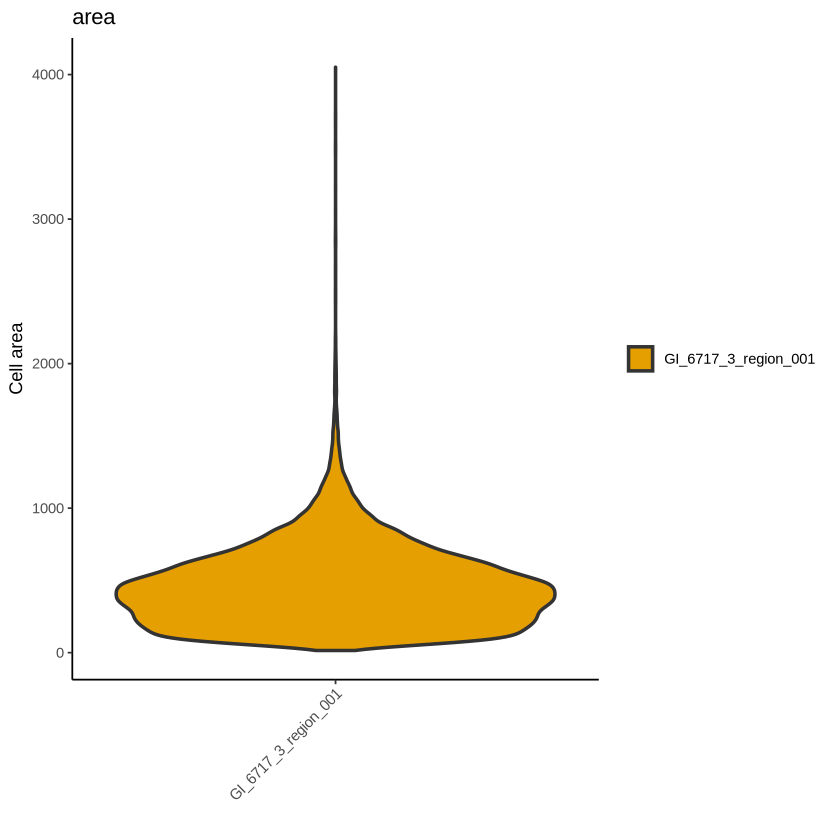

In [16]:
# Boxplot
dittoPlot(spe_QuPath_ananya, var = "area", 
          group.by = "sample_id", 
          plots = "vlnplot") + 
  ylab("Cell area") + xlab("")

This can be modified depending on what is relevant to the dataset

In [17]:
spe_QuPath_ananya <- spe_QuPath_ananya[,spe_QuPath_ananya$area >= 10] #this is because multiplexed imaging does not capture whole cells, but measures slices of cells. Small cellsare likely slices that are not representativ of the whole cell
spe_QuPath_ananya <- spe_QuPath_ananya[,spe_QuPath_ananya$area <= 3000] 
# I cut it down from 4000 to 2000

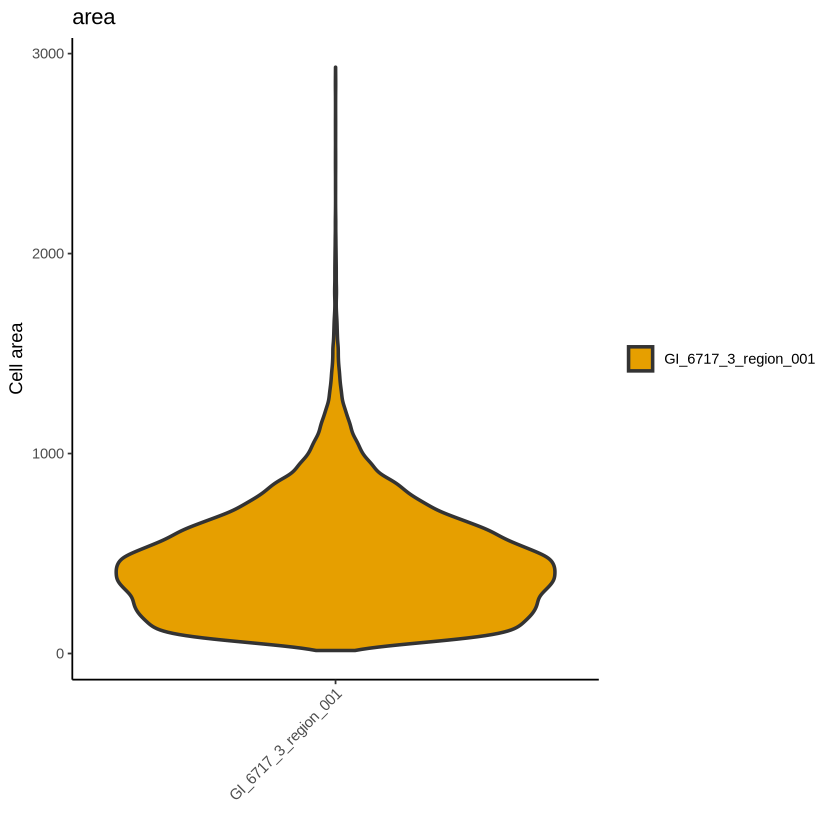

In [18]:
# Boxplot
dittoPlot(spe_QuPath_ananya, var = "area", 
          group.by = "sample_id", 
          plots = "vlnplot") + 
  ylab("Cell area") + xlab("")

In [20]:
saveRDS(spe_QuPath_ananya, fs::path_join(c(results_objects_dir, "spe_Qupath_ananya_post_filtering.rds")))
# spe <- readRDS(here("without_morpho","spe_post_filtering.rds"))